In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
import pudl
import pudl.constants as pc
import pudl.extract.ferc1

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 56

## High Level US Coal Operating Costs (\$/MWh) from EIA & FERC
 * 200-300 plants total.
 * Get EIA data by generator and FERC data by plant (PUDL and/or FERC Plant IDs)
 * Data years 2012-2017
 * FERC & EIA data mergeable by PUDL Plant ID (manually assigned)
 * Merged FERC data will be aggregated by PUDL Plant ID in cases where there are multiple owners reporting
 * Retain disaggregated FERC data in another Excel tab
 * Minimal data cleaning, relatively raw data output
 * 10 hours at \$75/hour Turn around: early next week.

In [4]:
pudl_out = pudl.output.pudltabl.PudlTabl(freq="MS", start_date="2012-01-01", end_date="2017-12-31")
steam_ferc1 = pudl_out.plants_steam_ferc1()
fuel_ferc1 = pudl_out.fuel_ferc1()

In [5]:
mcoe = pudl_out.mcoe()

/home/zane/anaconda3/envs/pudl/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
# For each plant record in the plants table, we need to be able to assign
# a fraction of heat content for that plant that came from a particlar fuel
# for filtering purposes. There are different ways that we can aggregate that
# information -- e.g. plant_id_pudl, plant_id_ferc1, (utility_id_ferc1, plant_name)
def coal_fraction(fuel_df, gb_cols=['plant_id_pudl']):
    """
    Calculate the fraction of overall heat content from coal
    per year and per gb_cols, which can be:
      - [plant_id_pudl]
      - [plant_id_ferc1]
      - [utility_id_ferc1, plant_name]
    
    Assumes fuel_df is a fuel_ferc1 dataframe.
    Cannot currently work for arbitrary fuel_type becuase not all plants
    have records for all fuel types.
    """
    gb_cols1 = ['report_year'] + gb_cols
    
    # Total heat content across all fuel types
    total_mmbtu = (
        fuel_df.groupby(gb_cols1).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        rename(columns={'fuel_consumed_mmbtu': 'total_mmbtu'})
    )
    
    # Same grouping... but also broken down by fuel type
    gb_cols2 = gb_cols1 + ['fuel_type_code_pudl']
    out_df = (
        fuel_df[fuel_df.fuel_type_code_pudl=='coal'].
        groupby(gb_cols2).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        merge(total_mmbtu, how='left', on=gb_cols1).
        assign(coal_fraction=lambda x: x['fuel_consumed_mmbtu'] / x['total_mmbtu']).
        rename(columns={'fuel_consumed_mmbtu': 'coal_mmbtu'}).
        drop(['fuel_type_code_pudl'], axis=1)
    )
    return out_df

In [7]:
# Calculate total heat content of fuel by plant & year
fuel_consumed_mmbtu = (
    fuel_ferc1.loc[fuel_ferc1.report_year>=2012,:].
    groupby(['report_year', 'plant_id_pudl']).
    agg({'fuel_consumed_mmbtu': sum}).
    reset_index()
)

coal_fraction_by_plant_name = coal_fraction(fuel_ferc1.loc[fuel_ferc1.report_year>=2012,:], ['utility_id_ferc1', 'plant_name'])

steam_agg_ferc1 = (
    # Only interested in 2012 and later
    steam_ferc1.loc[steam_ferc1.report_year>=2012,:].
    # This ensures we only include plants that use *some* coal
    merge(coal_fraction_by_plant_name, how='inner', on=['report_year', 'utility_id_ferc1', 'plant_name']).
    # Break out the non-fuel OpEx
    assign(opex_nonfuel=lambda x: x['opex_production_total'] - x['opex_fuel']).
    # Aggregate by plant_id_pudl
    groupby(['report_year','plant_id_pudl']).
    agg({'capacity_mw': sum,
         'net_generation_mwh': sum,
         'opex_fuel': sum,
         'opex_nonfuel': sum}).
    reset_index().
    # Bring in total heat content per pudl_plant
    merge(fuel_consumed_mmbtu, how='left', on=['report_year', 'plant_id_pudl']).
    # Calculate some other interesting metrics:
    assign(opex_fuel_per_mwh=lambda x: x['opex_fuel'] / x['net_generation_mwh'],
           opex_nonfuel_per_mwh=lambda x: x['opex_nonfuel'] / x['net_generation_mwh'],
           heat_rate_mmbtu_mwh=lambda x: x['fuel_consumed_mmbtu'] / x['net_generation_mwh'],
           capacity_factor=lambda x: x['net_generation_mwh'] / (8760*x['capacity_mw']),
           opex_total_per_mwh=lambda x: x['opex_nonfuel_per_mwh'] + x['opex_fuel_per_mwh'])
)

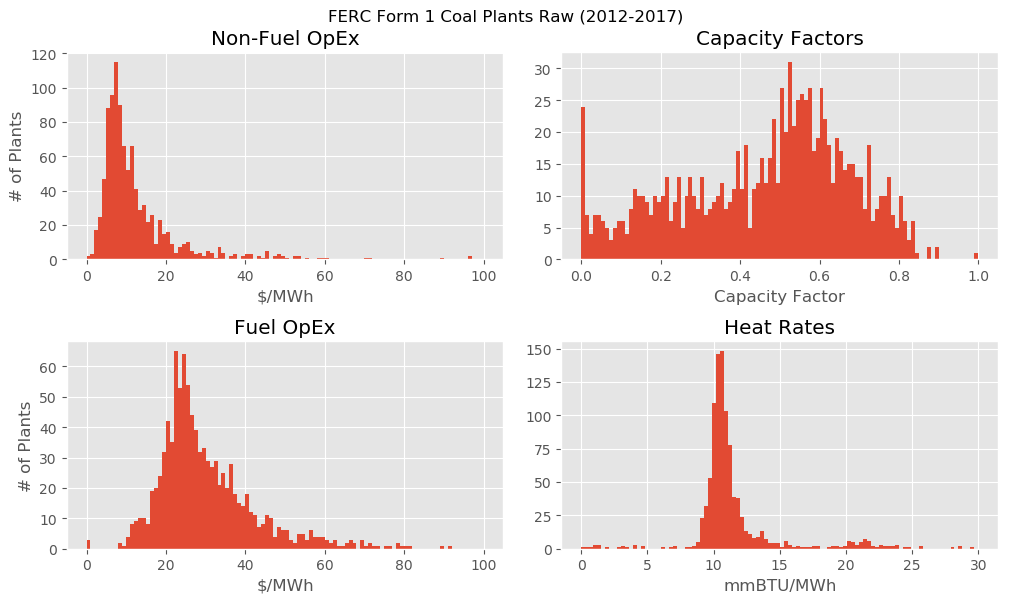

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=2, constrained_layout=True)

fig.suptitle('FERC Form 1 Coal Plants Raw (2012-2017)')

axs[0,0].hist(steam_agg_ferc1.opex_nonfuel_per_mwh, range=(0,100), bins=100);
axs[0,0].set_title('Non-Fuel OpEx')
axs[0,0].set_xlabel('$/MWh')
axs[0,0].set_ylabel('# of Plants')

axs[0,1].hist(steam_agg_ferc1.capacity_factor, range=(0,1), bins=100);
axs[0,1].set_title('Capacity Factors')
axs[0,1].set_xlabel('Capacity Factor')

axs[1,0].hist(steam_agg_ferc1.opex_fuel_per_mwh, range=(0,100), bins=100)
axs[1,0].set_title('Fuel OpEx')
axs[1,0].set_xlabel('$/MWh')
axs[1,0].set_ylabel('# of Plants')

axs[1,1].hist(steam_agg_ferc1.heat_rate_mmbtu_mwh, range=(0,30), bins=100)
axs[1,1].set_title('Heat Rates')
axs[1,1].set_xlabel('mmBTU/MWh')

plt.savefig('raw_ferc_hist.png')

plt.show();

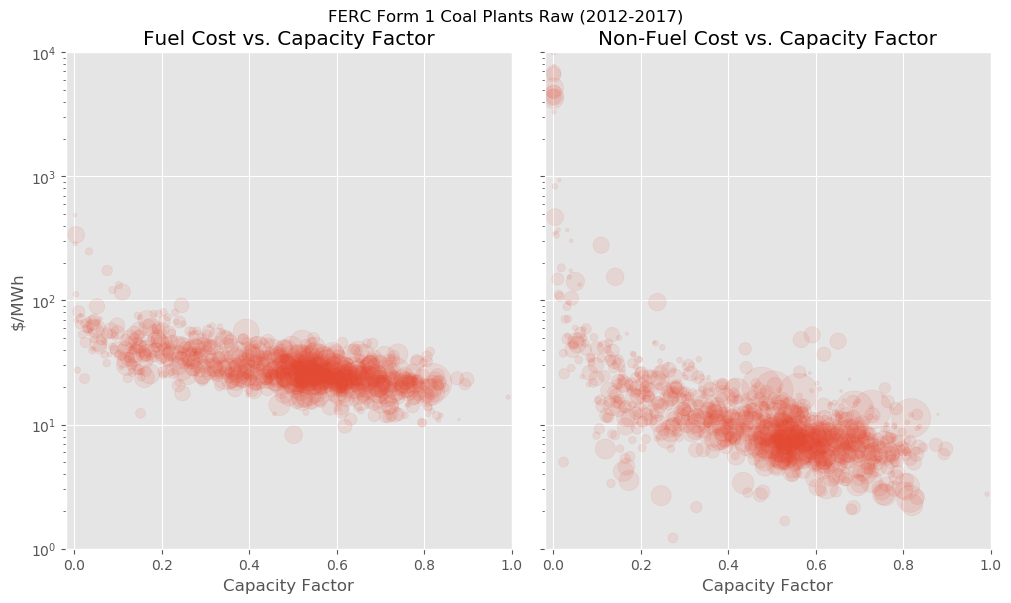

In [9]:
fig, axs = plt.subplots(ncols=2, nrows=1, constrained_layout=True, sharey=True)
fig.suptitle('FERC Form 1 Coal Plants Raw (2012-2017)')

axs[0].scatter(steam_agg_ferc1.capacity_factor, steam_agg_ferc1.opex_fuel_per_mwh, s=steam_agg_ferc1.capacity_mw/10, alpha=0.1)
axs[0].set_yscale('log')
axs[0].set_xlabel('Capacity Factor')
axs[0].set_xlim(-0.02,1)
axs[0].set_ylabel('$/MWh')
axs[0].set_ylim(1e0,1e4)
axs[0].set_title('Fuel Cost vs. Capacity Factor')

axs[1].scatter(steam_agg_ferc1.capacity_factor, steam_agg_ferc1.opex_nonfuel_per_mwh, s=steam_agg_ferc1.capacity_mw/10, alpha=0.1)
axs[1].set_yscale('log')
axs[1].set_xlabel('Capacity Factor')
axs[1].set_xlim(-0.02,1)
axs[1].set_ylim(1e0,1e4)
axs[1].set_title('Non-Fuel Cost vs. Capacity Factor')

plt.savefig('mcoe_vs_capfac.png')

plt.show();

In [10]:
eia_cols = [
    'report_date',
    'plant_id_eia',
    'plant_id_pudl',
    'unit_id_pudl',
    'generator_id',
    'plant_name',
    'utility_id_eia',
    'utility_id_pudl',
    'utility_name',
    'capacity_factor',
    'fuel_cost_per_mwh',
    'fuel_type_code_pudl',
    'heat_rate_mmbtu_mwh',
    #'capacity_mw',
    #'net_generation_mwh',
    #'total_fuel_cost',
    #'fuel_cost_per_mmbtu',
    #'total_mmbtu',
]
ferc_cols = [
    'report_year',
    'plant_id_pudl',
    'opex_fuel_per_mwh',
    'opex_nonfuel_per_mwh',
    'heat_rate_mmbtu_mwh',
    'capacity_factor',
    #'capacity_mw',
    #'net_generation_mwh',
    #'opex_fuel',
    #'opex_nonfuel',
    #'fuel_consumed_mmbtu',
]

## Merging FERC & EIA together
* FERC is annual, EIA is monthly
* Before we kept EIA monthly b/c some years had bad (NA) months and aggregating to annual meant losing the whole year.
* This means that the merge has a *lot* of FERC data duplication
* Annual records are broadcast across all months of EIA
* PUDL Plant ID level aggregation is broadcast across all unit_id_pudl values in EIA
* Different sampling scales (both time and generation unit granularity) means only ratio are comparable
* Can compare cost / MWh but not absolute cost, heat rate but not fuel heat content.
* Need to figure out a way to plot this data for a single plant such that it's visually clear how well EIA & FERC values match
* Can do a scatter plot of the same values from both datasets (perfect match = diagonal line)
* Can plot the same values in both datasets against time on the x-axis

In [11]:
plant_ids_2017 = mcoe[(mcoe.report_date.dt.year==2017) &
                      (mcoe.fuel_type_code_pudl=='coal')].plant_id_pudl.unique()
mcoe_both = (
    # Keep only the relevant mcoe_cols
    mcoe.loc[:,eia_cols].
    # Keep only record pertaining to plants that reported in 2017
    loc[(mcoe.plant_id_pudl.isin(plant_ids_2017)) &
        (mcoe.fuel_type_code_pudl=='coal'),:].
    drop(['fuel_type_code_pudl'], axis=1).
    # Create an EIA report year to merge on
    assign(report_year=lambda x: x['report_date'].dt.year).
    rename(columns={'fuel_cost_per_mwh':'opex_fuel_per_mwh'}).
    # Merge with FERC on year and plant_id_pudl
    merge(steam_agg_ferc1[ferc_cols], how='left', on=['report_year', 'plant_id_pudl'], suffixes=('_eia', '_ferc'))
)

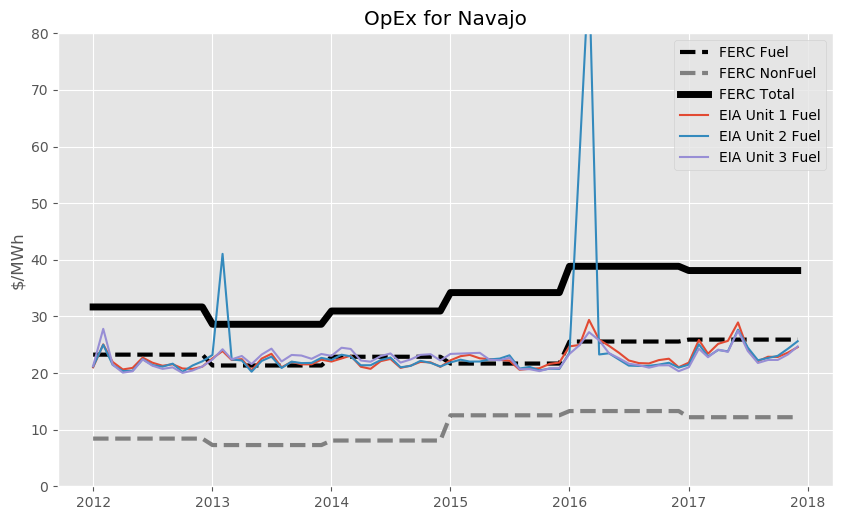

,report_date,plant_id_eia,plant_id_pudl,unit_id_pudl,generator_id,plant_name,utility_id_eia,utility_id_pudl,utility_name,capacity_factor_eia,opex_fuel_per_mwh_eia,heat_rate_mmbtu_mwh_eia,report_year,opex_fuel_per_mwh_ferc,opex_nonfuel_per_mwh,heat_rate_mmbtu_mwh_ferc,capacity_factor_ferc,opex_total_per_mwh_ferc
19841,2012-01-01,4941,404,1,NAV1,Navajo,16572,3081,Salt River Project,0.873099,21.007931,9.457156,2012,23.246839,8.420332,10.071661,0.643662,31.667171
19912,2012-01-01,4941,404,2,NAV2,Navajo,16572,3081,Salt River Project,0.822974,21.162398,9.526692,2012,23.246839,8.420332,10.071661,0.643662,31.667171
19983,2012-01-01,4941,404,3,NAV3,Navajo,16572,3081,Salt River Project,0.801133,21.235604,9.559647,2012,23.246839,8.420332,10.071661,0.643662,31.667171
19842,2012-02-01,4941,404,1,NAV1,Navajo,16572,3081,Salt River Project,0.875798,25.058757,10.031699,2012,23.246839,8.420332,10.071661,0.643662,31.667171
19913,2012-02-01,4941,404,2,NAV2,Navajo,16572,3081,Salt River Project,0.757274,24.996656,10.006838,2012,23.246839,8.420332,10.071661,0.643662,31.667171
19984,2012-02-01,4941,404,3,NAV3,Navajo,16572,3081,Salt River Project,0.075469,27.804385,11.130848,2012,23.246839,8.420332,10.071661,0.643662,31.667171
19843,2012-03-01,4941,404,1,NAV1,Navajo,16572,3081,Salt River Project,0.765503,21.951483,10.298436,2012,23.246839,8.420332,10.071661,0.643662,31.667171
19914,2012-03-01,4941,404,2,NAV2,Navajo,16572,3081,Salt River Project,0.773670,21.445750,10.061174,2012,23.246839,8.420332,10.071661,0.643662,31.667171
19985,2012-03-01,4941,404,3,NAV3,Navajo,16572,3081,Salt River Project,0.665420,21.484333,10.079275,2012,23.246839,8.420332,10.071661,0.643662,31.667171
19844,2012-04-01,4941,404,1,NAV1,Navajo,16572,3081,Salt River Project,0.664048,20.634592,10.322457,2012,23.246839,8.420332,10.071661,0.643662,31.667171


In [12]:
# choose a random plant:
pid=np.random.choice(mcoe_both.plant_id_pudl.unique())
mcoe_test = (
    mcoe_both.loc[mcoe_both.plant_id_pudl==pid,:].
    sort_values(['report_date', 'unit_id_pudl']).
    assign(opex_total_per_mwh_ferc=lambda x: x['opex_fuel_per_mwh_ferc'] +x['opex_nonfuel_per_mwh'])
)
plt.plot(mcoe_test.report_date, mcoe_test.opex_fuel_per_mwh_ferc, label="FERC Fuel", lw=3, color='black', ls='dashed')
plt.plot(mcoe_test.report_date, mcoe_test.opex_nonfuel_per_mwh, label="FERC NonFuel", lw=3, color='gray', ls='dashed')
plt.plot(mcoe_test.report_date, mcoe_test.opex_total_per_mwh_ferc, label="FERC Total", lw=5, color='black')

for unit_id in mcoe_test.unit_id_pudl.unique():
    mcoe_unit = mcoe_test[mcoe_test.unit_id_pudl==unit_id]
    plt.plot(mcoe_unit.report_date, mcoe_unit.opex_fuel_per_mwh_eia, label=f"EIA Unit {unit_id} Fuel")
plant_name = mcoe_test.plant_name.unique()[0]
plt.title(f'OpEx for {plant_name}')
plt.ylabel("$/MWh")
plt.ylim(0,80)
plt.legend()
plt.show()
mcoe_test